# Omri Shem Tov, Niv Moshe
# Causal Inference Project

# Data Preperations

In [ ]:
!pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 406 kB 5.1 MB/s 
     |████████████████████████████████| 569 kB 44.9 MB/s 
     |████████████████████████████████| 1.8 MB 44.3 MB/s 
     |████████████████████████████████| 718 kB 44.6 MB/s 
  Created wheel for causalml: filename=causalml-0.12.3-cp37-cp37m-linux_x86_64.whl size=1053946 sha256=cacefaca863dbbee27ba1783810fe8ea20e99fffb809f9b421019dbfcff08fca
  Stored in directory: /root/.cache/pip/wheels/d7/5e/47/4e965cf8e87c6c10cd7361d910acccd08a1de459f25d55fd23
Successfully built causalml


In [ ]:
# imports here
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsRegressor
import sklearn
import re

from xgboost import XGBRegressor
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor, BaseDRRegressor, XGBDRRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.inference.iv import BaseDRIVRegressor

from tqdm import tqdm
import os
import warnings
import datetime as dt
import matplotlib.pyplot as plt
np.random.seed(42)

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## A function to fix wrong dates in our data

In [ ]:
def change_year(date_df,  CL=False):
  # the 2019-20 season usually ends before august-september of 2020
  if CL:
    if date_df.year == 2020 and date_df.month > 9:
      date_df = date_df.replace(year = 2019)
  else:
    if date_df.year == 2020 and date_df.month > 7:
      date_df = date_df.replace(year = 2019)
 # the 2019-20 season usually starts in august-september of 2019
  if date_df.year == 2019 and date_df.month == 1:
    date_df = date_df.replace(year = 2020)
  return date_df

## Reading data from each league and concatenating all together

In [ ]:
xls = pd.ExcelFile('19-20XL_V2.xlsx')
df1 = pd.read_excel(xls, 'SA2 19-20')
df2 = pd.read_excel(xls, 'SA1 19-20')
df3 = pd.read_excel(xls, 'BUND 19-20')
df4 = pd.read_excel(xls, 'CL 19-20')
df5 = pd.read_excel(xls, 'PL 19-20')

df3["Date"] = df3["Date"].astype("datetime64")
df4["Date"] = df4["Date"].astype("datetime64")
df5["Date"] = df5["Date"].astype("datetime64")

# fix wrong dates in these leagues
df3['Date'] = df3['Date'].apply(lambda x: change_year(x))
df4['Date'] = df4['Date'].apply(lambda x: change_year(x, CL=True))
df5['Date'] = df5['Date'].apply(lambda x: change_year(x))

df6 = pd.read_excel(xls, 'ligue1 19-20')
df = pd.concat([df1, df2, df3, df4, df5, df6])
df

,REF,Competition,Journee,Date,Home team,Away team,Team taking pen,Pen taker,Minute,LtD game-changing pen,DtW game-changing pen,L no game-changing,W no game-changing,Scored,PT sub,PT position,Team win,Last Goal
0,1,SERIE A,20,2020-01-18,Lazio,Sampdoria,Home,Ciro Immobile,17,NO,NO,NO,YES,YES,NO,ST,YES,NO
1,2,SERIE A,20,2020-01-18,Lazio,Sampdoria,Home,Ciro Immobile,65,NO,NO,NO,YES,YES,NO,ST,YES,NO
2,3,SERIE A,20,2020-01-19,Brescia,Cagliari,Away,Joao Pedro,68,YES,NO,NO,NO,YES,NO,OM,NO,YES
3,4,SERIE A,21,2020-01-25,SPAL,Bologne,Home,Andrea Petagna,23,NO,YES,NO,NO,YES,NO,ST,NO,NO
4,5,SERIE A,21,2020-01-25,Fiorentina,Genoa,Away,Domenico Criscito,15,NO,YES,NO,NO,NO,NO,CB,NO,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,88,Ligue 1,28,2020-03-06,Marseille,Amiens,Away,Sehrou Guirassy,83,NO,NO,YES,NO,YES,NO,ST,NO,NO
88,89,Ligue 1,28,2020-03-07,Reims,Brest,Away,Alexandre Mendy,29,NO,YES,NO,NO,NO,NO,ST,NO,NOT GOAL
89,90,Ligue 1,28,2020-03-07,Reims,Brest,Home,El Bilal Toure,37,NO,YES,NO,NO,YES,NO,ST,YES,YES
90,91,Ligue 1,28,2020-03-08,Rennes,Montpellier,Home,Romain Del Castillo,73,NO,NO,NO,YES,YES,NO,ST,YES,NO


In [ ]:
df.columns

Index(['REF', 'Competition', 'Journee', 'Date', 'Home team', 'Away team',
       'Team taking pen', 'Pen taker', 'Minute', 'LtD game-changing pen',
       'DtW game-changing pen', 'L no game-changing', 'W no game-changing',
       'Scored', 'PT sub', 'PT position', 'Team win', 'Last Goal'],
      dtype='object')

## Dropping unwanted columns

In [ ]:
columns_to_remove = ['Journee', 'LtD game-changing pen', 'DtW game-changing pen', 'L no game-changing', 'Team win', 'Last Goal']
df_dropped = df.drop(columns=columns_to_remove)
df_dropped

,REF,Competition,Date,Home team,Away team,Team taking pen,Pen taker,Minute,W no game-changing,Scored,PT sub,PT position
0,1,SERIE A,2020-01-18,Lazio,Sampdoria,Home,Ciro Immobile,17,YES,YES,NO,ST
1,2,SERIE A,2020-01-18,Lazio,Sampdoria,Home,Ciro Immobile,65,YES,YES,NO,ST
2,3,SERIE A,2020-01-19,Brescia,Cagliari,Away,Joao Pedro,68,NO,YES,NO,OM
3,4,SERIE A,2020-01-25,SPAL,Bologne,Home,Andrea Petagna,23,NO,YES,NO,ST
4,5,SERIE A,2020-01-25,Fiorentina,Genoa,Away,Domenico Criscito,15,NO,NO,NO,CB
...,...,...,...,...,...,...,...,...,...,...,...,...
87,88,Ligue 1,2020-03-06,Marseille,Amiens,Away,Sehrou Guirassy,83,NO,YES,NO,ST
88,89,Ligue 1,2020-03-07,Reims,Brest,Away,Alexandre Mendy,29,NO,NO,NO,ST
89,90,Ligue 1,2020-03-07,Reims,Brest,Home,El Bilal Toure,37,NO,YES,NO,ST
90,91,Ligue 1,2020-03-08,Rennes,Montpellier,Home,Romain Del Castillo,73,YES,YES,NO,ST


## Dropping a bad row (2010 doesn't belong to this data)

In [ ]:
df_dropped = df_dropped[df_dropped["Date"].dt.year != 2010]
# df_dropped = df_dropped[~((df_dropped["Date"].dt.month == 1) & (df_dropped["Date"].dt.year == 2019))]
# drop one row which is fucked
df_dropped.reset_index(inplace=True)
df_dropped.drop('index', axis=1, inplace=True)
df_dropped

,REF,Competition,Date,Home team,Away team,Team taking pen,Pen taker,Minute,W no game-changing,Scored,PT sub,PT position
0,1,SERIE A,2020-01-18,Lazio,Sampdoria,Home,Ciro Immobile,17,YES,YES,NO,ST
1,2,SERIE A,2020-01-18,Lazio,Sampdoria,Home,Ciro Immobile,65,YES,YES,NO,ST
2,3,SERIE A,2020-01-19,Brescia,Cagliari,Away,Joao Pedro,68,NO,YES,NO,OM
3,4,SERIE A,2020-01-25,SPAL,Bologne,Home,Andrea Petagna,23,NO,YES,NO,ST
4,5,SERIE A,2020-01-25,Fiorentina,Genoa,Away,Domenico Criscito,15,NO,NO,NO,CB
...,...,...,...,...,...,...,...,...,...,...,...,...
488,88,Ligue 1,2020-03-06,Marseille,Amiens,Away,Sehrou Guirassy,83,NO,YES,NO,ST
489,89,Ligue 1,2020-03-07,Reims,Brest,Away,Alexandre Mendy,29,NO,NO,NO,ST
490,90,Ligue 1,2020-03-07,Reims,Brest,Home,El Bilal Toure,37,NO,YES,NO,ST
491,91,Ligue 1,2020-03-08,Rennes,Montpellier,Home,Romain Del Castillo,73,YES,YES,NO,ST


# Data analysis and Visualization

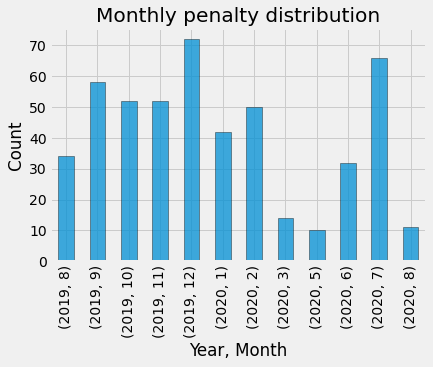

In [ ]:
df_dropped["Date"] = df_dropped["Date"].astype("datetime64")
df_dropped['Date'].groupby([df_dropped["Date"].dt.year, df_dropped["Date"].dt.month]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
# plt.xticks(range(2), ['2019', '2020'])
plt.ylabel('Count')
plt.xlabel('Year, Month')
plt.title('Monthly penalty distribution')
plt.show()

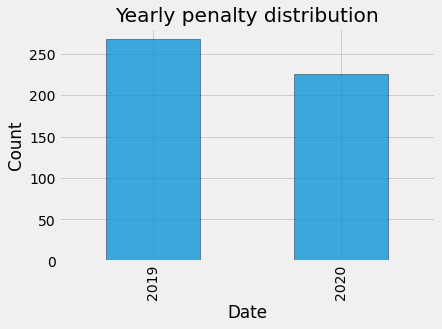

In [ ]:
df_dropped['Date'].groupby([df_dropped["Date"].dt.year]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xticks(range(2), ['2019', '2020'])
plt.ylabel('Count')
plt.title('Yearly penalty distribution')
plt.show()

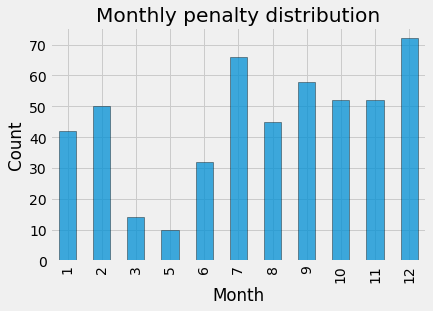

In [ ]:
df_dropped["Date"] = df_dropped["Date"].astype("datetime64")
df_dropped['Date'].groupby(df_dropped["Date"].dt.month).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly penalty distribution')
plt.show()

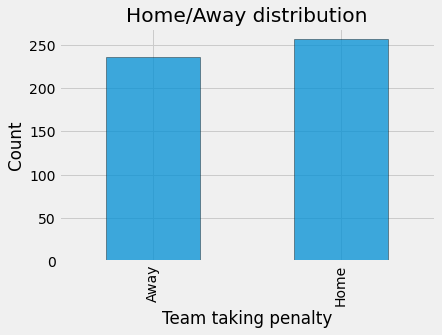

In [ ]:
df_dropped['Team taking pen'].groupby(df_dropped["Team taking pen"]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xlabel('Team taking penalty')
plt.ylabel('Count')
plt.title('Home/Away distribution')
plt.show()

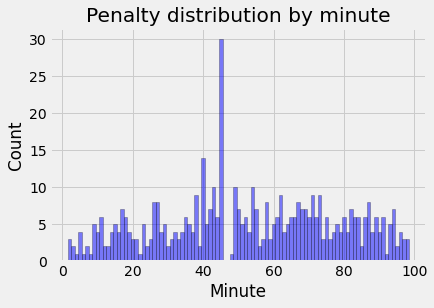

In [ ]:
df_dropped['Minute'].groupby(df_dropped["Minute"]).plot(kind="hist", bins=1, edgecolor='black', alpha=0.5, color='blue')
plt.xlabel('Minute')
plt.ylabel('Count')
plt.title('Penalty distribution by minute')
plt.show()

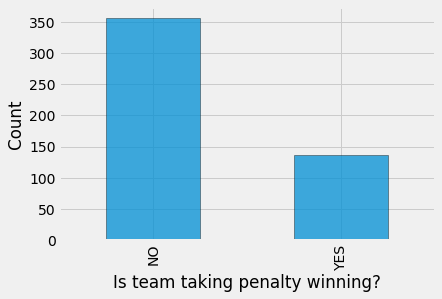

In [ ]:
df_dropped['W no game-changing'].groupby(df_dropped["W no game-changing"]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xlabel('Is team taking penalty winning?')
plt.ylabel('Count')
plt.show()

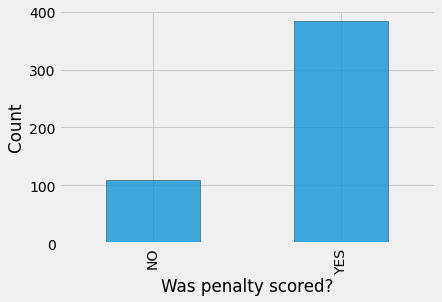

In [ ]:
df_dropped['Scored'].groupby(df_dropped["Scored"]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xlabel('Was penalty scored?')
plt.ylabel('Count')
plt.show()

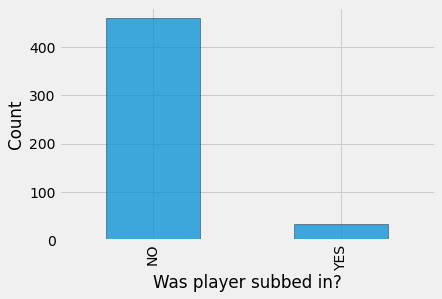

In [ ]:
df_dropped['PT sub'].groupby(df_dropped["PT sub"]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xlabel('Was player subbed in?')
plt.ylabel('Count')
plt.show()

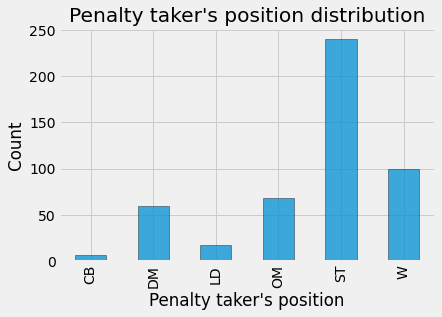

In [ ]:
df_dropped['PT position'].groupby(df_dropped["PT position"]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xlabel('Penalty taker\'s position')
plt.ylabel('Count')
plt.title('Penalty taker\'s position distribution')
plt.show()

In [ ]:
df_dropped['Team taking pen'] = df_dropped['Team taking pen'].map({'Home': 0, 'Away': 1})
df_dropped['W no game-changing'] = df_dropped['W no game-changing'].map({'YES': 1, 'NO': 0})
df_dropped['Scored'] = df_dropped['Scored'].map({'YES': 1, 'NO': 0})
df_dropped['PT sub'] = df_dropped['PT sub'].map({'YES': 1, 'NO': 0})

# Causal effects estimation

## Splitting the Date column into many columns

In [ ]:
# Add date part code (from fast.ai 0.7)
# the following features will be extracted for each date:
# features = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
#                            'Is_quarter_end', 'Is_quarter_start',  'Is_year_end', 'Is_year_start']
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [ ]:
add_datepart(df_dropped, 'Date')

In [ ]:
# drop columns we don't need
df_dropped.drop('Elapsed', axis=1, inplace=True)  # elapsed will be the time stamp
df_dropped.drop(['Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',  'Is_year_end', 'Is_year_start'], axis=1, inplace=True)
df_dropped

,REF,Competition,Home team,Away team,Team taking pen,Pen taker,Minute,W no game-changing,Scored,PT sub,PT position,Year,Month,Week,Day,Dayofweek,Dayofyear
0,1,SERIE A,Lazio,Sampdoria,0,Ciro Immobile,17,1,1,0,ST,2020,1,3,18,5,18
1,2,SERIE A,Lazio,Sampdoria,0,Ciro Immobile,65,1,1,0,ST,2020,1,3,18,5,18
2,3,SERIE A,Brescia,Cagliari,1,Joao Pedro,68,0,1,0,OM,2020,1,3,19,6,19
3,4,SERIE A,SPAL,Bologne,0,Andrea Petagna,23,0,1,0,ST,2020,1,4,25,5,25
4,5,SERIE A,Fiorentina,Genoa,1,Domenico Criscito,15,0,0,0,CB,2020,1,4,25,5,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,88,Ligue 1,Marseille,Amiens,1,Sehrou Guirassy,83,0,1,0,ST,2020,3,10,6,4,66
489,89,Ligue 1,Reims,Brest,1,Alexandre Mendy,29,0,0,0,ST,2020,3,10,7,5,67
490,90,Ligue 1,Reims,Brest,0,El Bilal Toure,37,0,1,0,ST,2020,3,10,7,5,67
491,91,Ligue 1,Rennes,Montpellier,0,Romain Del Castillo,73,1,1,0,ST,2020,3,10,8,6,68


## Defining our covariates

In [ ]:
df_dumpy = pd.get_dummies(df_dropped)
x_covariates = list(df_dumpy.columns.difference(["Scored", "Team taking pen", "REF"]))
np.array(x_covariates)

array(['Away team_AC Milan', 'Away team_Ajax', 'Away team_Amiens',
       'Away team_Arsenal', 'Away team_Aston Villa', 'Away team_Atalanta',
       'Away team_Augsbourg', 'Away team_Barcelone', 'Away team_Bayern',
       'Away team_Bayern Munich', 'Away team_Benfica',
       'Away team_Bologne', 'Away team_Bordeaux',
       'Away team_Borussia Monchen', 'Away team_Bournemouth',
       'Away team_Brescia', 'Away team_Brest', 'Away team_Brighton',
       'Away team_Burnley', 'Away team_Cagliari', 'Away team_Chelsea',
       'Away team_Club Bruges', 'Away team_Cologne',
       'Away team_Crystal Palace', 'Away team_Dijon',
       'Away team_Dinamo Zagreb', 'Away team_Dortmund',
       'Away team_Dusseldorf', 'Away team_Eintracht Francfort',
       'Away team_Etoile Rouge Belgrade', 'Away team_Everton',
       'Away team_Fiorentina', 'Away team_Fribourg',
       'Away team_Galatasaray', 'Away team_Genk', 'Away team_Genoa',
       'Away team_Herta Berlin', 'Away team_Hoffenheim',
       'A

## Scaling the data

In [ ]:
scaler = MinMaxScaler()

df_dumpy[x_covariates] = scaler.fit_transform(df_dumpy[x_covariates])

x = df_dumpy[x_covariates].values
t = df_dumpy["Team taking pen"].values
y = df_dumpy['Scored'].values

In [ ]:
# calculating propensity scores using logistic regression
propensity_data1 = make_pipeline(CalibratedClassifierCV(LogisticRegression())).fit(x, t)
df_dumpy['P'] = propensity_data1.predict_proba(x)[:, 1]
p1 = df_dumpy['P'].values

In [ ]:
x_covariates_with_p = list(df_dumpy.columns.difference(["Scored", "Team taking pen", "REF"]))
np.array(x_covariates_with_p)

array(['Away team_AC Milan', 'Away team_Ajax', 'Away team_Amiens',
       'Away team_Arsenal', 'Away team_Aston Villa', 'Away team_Atalanta',
       'Away team_Augsbourg', 'Away team_Barcelone', 'Away team_Bayern',
       'Away team_Bayern Munich', 'Away team_Benfica',
       'Away team_Bologne', 'Away team_Bordeaux',
       'Away team_Borussia Monchen', 'Away team_Bournemouth',
       'Away team_Brescia', 'Away team_Brest', 'Away team_Brighton',
       'Away team_Burnley', 'Away team_Cagliari', 'Away team_Chelsea',
       'Away team_Club Bruges', 'Away team_Cologne',
       'Away team_Crystal Palace', 'Away team_Dijon',
       'Away team_Dinamo Zagreb', 'Away team_Dortmund',
       'Away team_Dusseldorf', 'Away team_Eintracht Francfort',
       'Away team_Etoile Rouge Belgrade', 'Away team_Everton',
       'Away team_Fiorentina', 'Away team_Fribourg',
       'Away team_Galatasaray', 'Away team_Genk', 'Away team_Genoa',
       'Away team_Herta Berlin', 'Away team_Hoffenheim',
       'A

## Plotting propensity score overlap

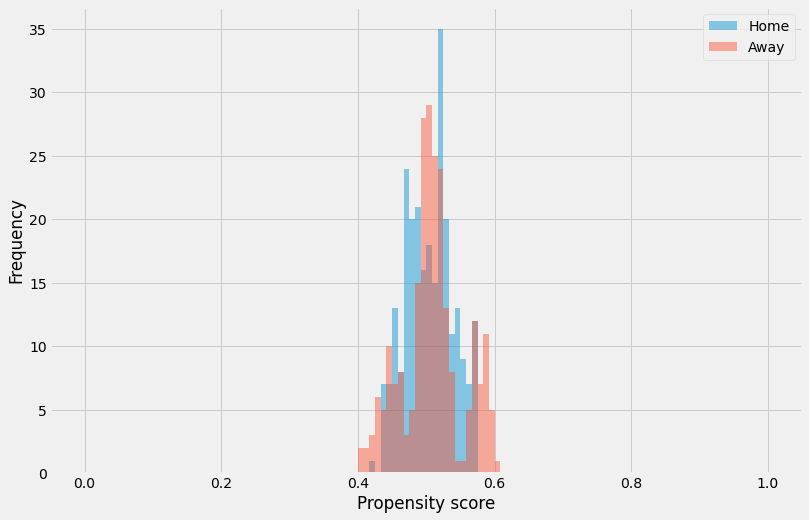

In [ ]:
plt.figure(figsize=(12,8))
df_dumpy.groupby("Team taking pen")["P"].plot(kind="hist", sharex=True, range=(0,1), bins=120, alpha=0.45, legend=True)
plt.legend(['Home', 'Away'])
plt.xlabel('Propensity score')
plt.show()

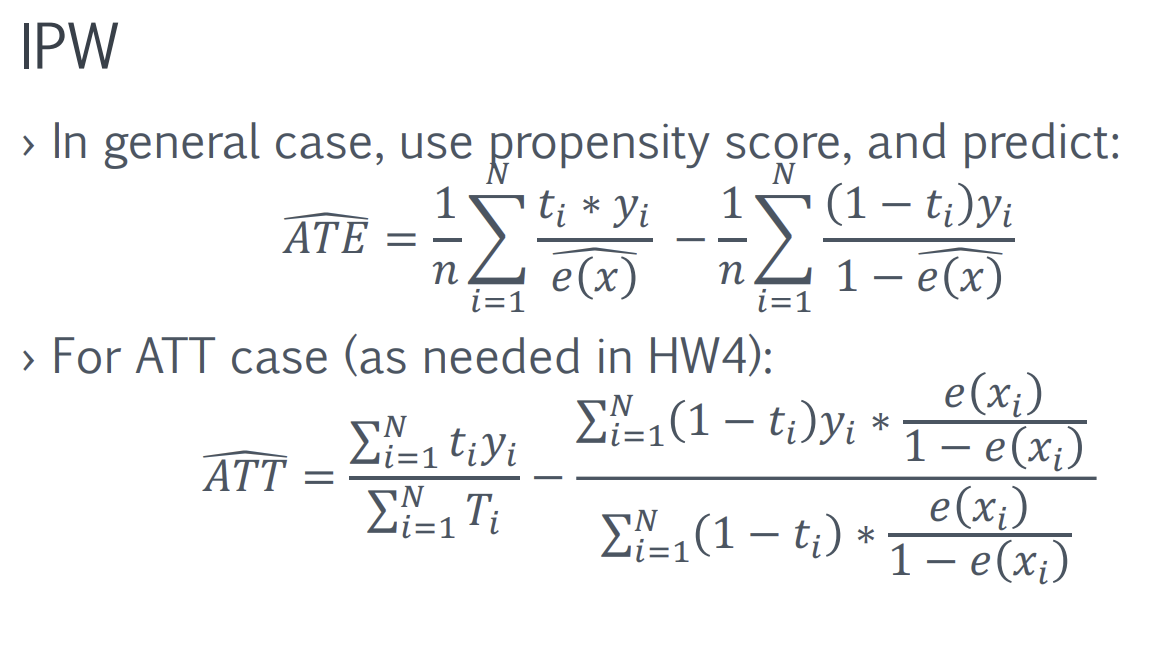

In [ ]:
# calculate ATE and ATT using IPW

def ipw(df):
    y = df['Scored'].values
    t = df['Team taking pen'].values
    p = df['P'].values
    ATE = ((y[t == 1]/p[t == 1]).sum() - (y[t == 0]/(1-p[t == 0])).sum()) / y.shape[0]
    mean_y1_att = y[t == 1].sum() / t.sum()
    numerator = (y[t == 0] * (p[t == 0]/(1-p[t == 0]))).sum()    
    denominator = (p[t == 0]/(1-p[t == 0])).sum()
    mean_y2_att = numerator / denominator
    ATT = mean_y1_att - mean_y2_att
    return ATT, ATE

In [ ]:
np.random.seed(42)
p_ATT, p_ATE = ipw(df_dumpy)
p_ATT, p_ATE

(-0.061699369678020144, -0.14979084748675775)

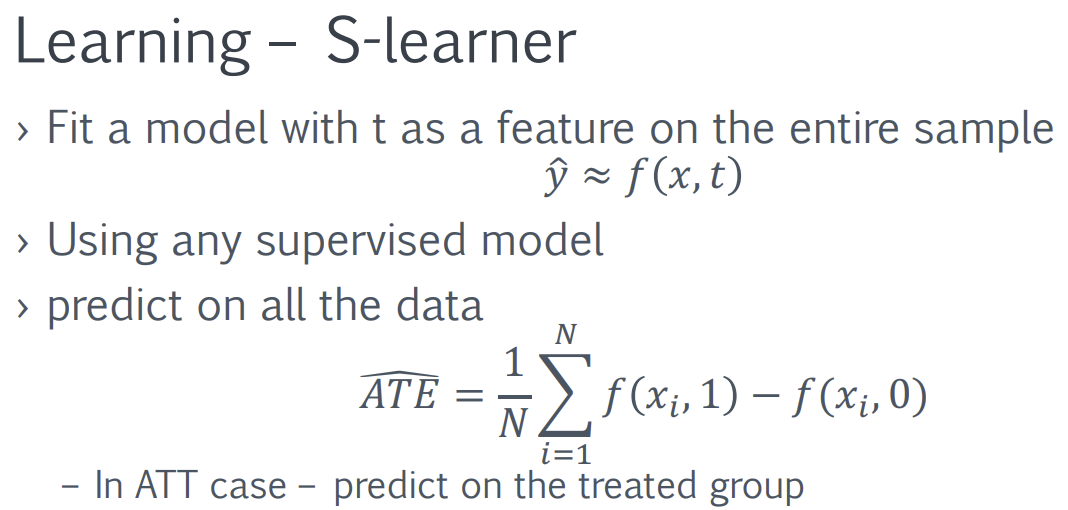

In [ ]:
# plotting ATE and ATT using s-learner

def s_learner(df, x_covariates):
    # getting data
    df_covariates = df[x_covariates + ['Team taking pen']]
    x = df_covariates.values
    x_treated = df_covariates[df_covariates['Team taking pen'] == 1]
    x_control = df_covariates[df_covariates['Team taking pen'] == 0]
    y = df['Scored'].values
    t = df['Team taking pen'].values
    
    # defining model
    model = GradientBoostingRegressor()
    model.fit(x, y)
    # model = make_pipeline(StandardScaler(), GradientBoostingRegressor()).fit(x, y)
    # model = LinearRegression()
    
    # making counter factual for ATT
    x_counter_factual = x_treated.copy()
    x_counter_factual['Team taking pen'] = 0
    
    # predicting using s-learner - predict on the treated group
    x_treat_predict = model.predict(x_treated.values)
    x_counter_factual_predict = model.predict(x_counter_factual.values)
    
    sum_diff1 = (x_treat_predict.sum() - x_counter_factual_predict.sum())  
    ATT = sum_diff1 / len(x_treated)

    # dealing with control
    # making counter factual
    x_counter_factual_control = x_control.copy()
    x_counter_factual_control['Team taking pen'] = 1
    # predicting using s-learner - predict on the treated group
    x_control_predict = model.predict(x_control.values)
    x_counter_factual_control_predict = model.predict(x_counter_factual_control.values)
    sum_diff2 = (x_counter_factual_control_predict.sum() - x_control_predict.sum())
    ATE = (sum_diff1 + sum_diff2) / len(x)
    return ATT, ATE

In [ ]:
np.random.seed(42)
s_ATT, s_ATE = s_learner(df_dumpy, x_covariates)
s_ATT, s_ATE

(-0.007679152950644179, -0.006899795826446198)

In [ ]:
np.random.seed(42)
s_ATT_with_p, s_ATE_with_p = s_learner(df_dumpy, x_covariates_with_p)
s_ATT_with_p, s_ATE_with_p

(-0.0060509775500591206, -0.005682454546670702)

In [ ]:
x = df_dumpy[x_covariates].values
t = df_dumpy["Team taking pen"].values
y = df_dumpy['Scored'].values
np.random.seed(42)
# Ready-to-use S-Learner using LinearRegression
learner_s = BaseSRegressor(learner=GradientBoostingRegressor())
ate_s = learner_s.estimate_ate(X=x, treatment=t, y=y, return_ci=True)
# print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

ATE estimate: -0.007
ATE lower bound: -0.063
ATE upper bound: 0.049


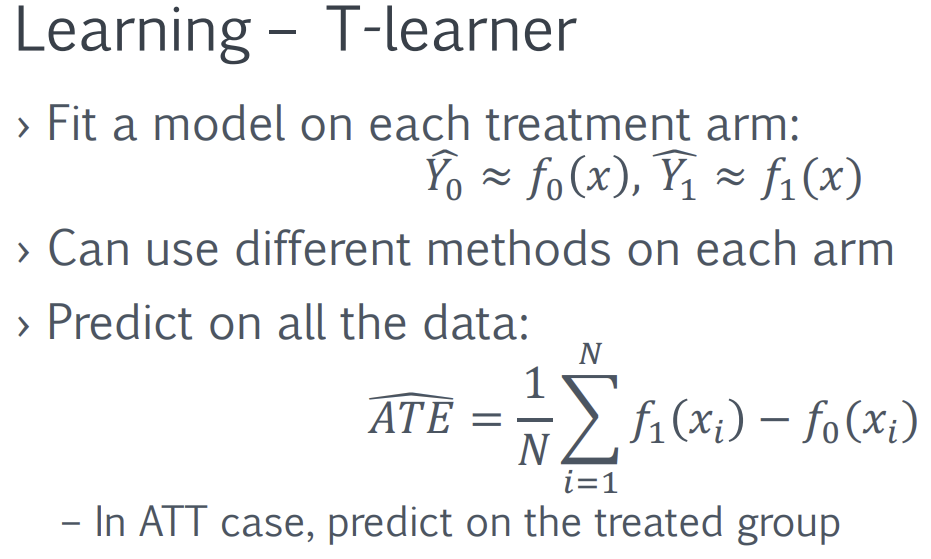

In [ ]:
# plotting ATE and ATT using t-learner

def t_learner(df, x_covariates):    
    # getting data
    # treated
    df_treated = df[df['Team taking pen'] == 1]
    x_treated = df_treated[x_covariates].values
    y_treated = df_treated['Scored'].values
    # non treated
    df_non_treated = df[df['Team taking pen'] == 0]
    x_non_treated = df_non_treated[x_covariates].values
    y_non_treated = df_non_treated['Scored'].values
    
    # models
    model_treated = GradientBoostingRegressor()
    model_treated.fit(x_treated, y_treated)
    model_non_treated = GradientBoostingRegressor()
    model_non_treated.fit(x_non_treated, y_non_treated)
    
    # predictions - predict on the treated group
    treated_predict = model_treated.predict(x_treated)
    non_treated_predict = model_non_treated.predict(x_treated)
    ATT = (treated_predict.sum() - non_treated_predict.sum()) / len(x_treated)

    x = df[x_covariates].values
    all_treated_predict = model_treated.predict(x)
    all_non_treated_predict = model_non_treated.predict(x)
    ATE = (all_treated_predict.sum() - all_non_treated_predict.sum()) / len(x)
    return ATT, ATE

In [ ]:
np.random.seed(42)
t_ATT, t_ATE = t_learner(df_dumpy, x_covariates)
t_ATT, t_ATE

(-0.10238605451101944, -0.05944570533585998)

In [ ]:
np.random.seed(42)
t_ATT_with_p, t_ATE_with_p = t_learner(df_dumpy, x_covariates_with_p)
t_ATT_with_p, t_ATE_with_p

(-0.10464855682991506, -0.06507100509748716)

In [ ]:
x = df_dumpy[x_covariates].values
t = df_dumpy["Team taking pen"].values
y = df_dumpy['Scored'].values
np.random.seed(42)

learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=x, treatment=t, y=y)
print(ate_t)
print('ATE estimate: {:.03f}'.format(ate_t[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_t[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_t[2][0]))

[09:10:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(array([-0.05963631]), array([-0.11336787]), array([-0.00590475]))
ATE estimate: -0.060
ATE lower bound: -0.113
ATE upper bound: -0.006


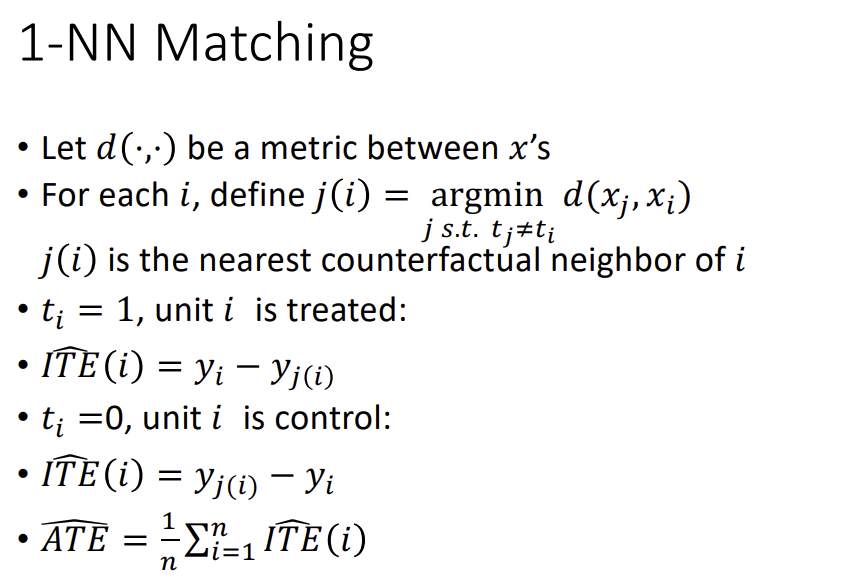

In [ ]:
# plotting ATE and ATT using matching

def matching(df, x_covariates):  
    # getting data
    # treated
    df_treated = df[df['Team taking pen'] == 1]
    x_treated = df_treated[x_covariates].values
    y_treated = df_treated['Scored'].values
    p_treated = df_treated['P'].values
    # non treated
    df_non_treated = df[df['Team taking pen'] == 0]
    x_non_treated = df_non_treated[x_covariates].values
    y_non_treated = df_non_treated['Scored'].values
    p_non_treated = df_non_treated['P'].values
    
    # models
    # method 1 - matching on covariates
    knn_non_treated = KNeighborsRegressor(n_neighbors=1)
    knn_non_treated.fit(x_non_treated, y_non_treated)  # model for matching counter factuals of treated
    knn_treated = KNeighborsRegressor(n_neighbors=1)
    knn_treated.fit(x_treated, y_treated)  # model for matching counter factuals of control
    
    ATE = 0
    ATT = 0
    for i, row_arr in enumerate(x_treated):
        y_prediction = knn_non_treated.predict([row_arr])[0]
        ATT += (y_treated[i] - y_prediction)  # summing on ITEs for treated
    ATE = ATT
    ATT = ATT / len(x_treated)

    # calculating second part for ATE
    for i, row_arr in enumerate(x_non_treated):
        y_prediction = knn_treated.predict([row_arr])[0]
        ATE += (y_prediction - y_non_treated[i])  # summing on ITEs for treated
    ATE /= (len(x_non_treated) + len(x_treated))
    
    
    # method 2 - matching on propensity
#     att2 = 0
#     for i in range(len(df_treated)):
#         distances = np.abs(p_non_treated - p_treated[i])
#         min_idx = distances.argmin()
#         att2 += (y_treated[i] - y_non_treated[min_idx])  # summing on ITEs for treated
#     att2 = att2 / len(df_treated)
    return ATT, ATE  # , att2

In [ ]:
np.random.seed(42)
match_ATT, match_ATE = matching(df_dumpy, x_covariates)
match_ATT, match_ATE

(-0.09745762711864407, -0.08113590263691683)

In [ ]:
np.random.seed(42)
match_ATT_with_p, match_ATE_with_p = matching(df_dumpy, x_covariates_with_p)
match_ATT_with_p, match_ATE_with_p

(-0.09745762711864407, -0.08113590263691683)

In [ ]:
pd.options.display.float_format = '{:.3f}'.format
ate_list = [p_ATE, s_ATE, t_ATE, match_ATE]
att_list = [p_ATT, s_ATT, t_ATT, match_ATT]

df_table = pd.DataFrame({'ATE': ate_list, 'ATT': att_list}, ['Propensity', 'S-learner', 'T-learner', 'Matching'])
df_table = df_table.style.set_caption('ATE and ATT per method')
df_table

,ATE,ATT
Propensity,-0.149791,-0.061699
S-learner,-0.006900,-0.007679
T-learner,-0.059446,-0.102386
Matching,-0.081136,-0.097458


In [ ]:
pd.options.display.float_format = '{:.3f}'.format
ate_list_with_p = [p_ATE, s_ATT_with_p, t_ATE_with_p, match_ATE_with_p]
att_list_with_p = [p_ATT, s_ATE_with_p, t_ATT_with_p, match_ATT_with_p]

df_table_with_p = pd.DataFrame({'ATE': ate_list_with_p, 'ATT': att_list_with_p}, ['Propensity', 'S-learner', 'T-learner', 'Matching'])
df_table_with_p = df_table_with_p.style.set_caption('ATE and ATT per method (with propensity')
df_table_with_p

,ATE,ATT
Propensity,-0.149791,-0.061699
S-learner,-0.006051,-0.005682
T-learner,-0.065071,-0.104649
Matching,-0.081136,-0.097458


Doubly Robust estimator

In [ ]:
# doubly robust estimation of ATE
x = df_dumpy[x_covariates].values
t = df_dumpy["Team taking pen"].values
y = df_dumpy['Scored'].values
np.random.seed(42)

# learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
learner_dr = XGBDRRegressor()
cate_dr = learner_dr.estimate_ate(X=x, treatment=t, y=y)
print(cate_dr)
print('ATE estimate: {:.03f}'.format(cate_dr[0][0]))
print('ATE lower bound: {:.03f}'.format(cate_dr[1][0]))
print('ATE upper bound: {:.03f}'.format(cate_dr[2][0]))

[09:11:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

# ATE and ATT under different sub-groups

In [ ]:
def ATE_AND_ATT(df, x_covariates, league):
  p_ATT, p_ATE = ipw(df)
  s_ATT, s_ATE = s_learner(df, x_covariates)
  t_ATT, t_ATE = t_learner(df, x_covariates)
  match_ATT, match_ATE = matching(df, x_covariates)

  ate_list = [p_ATE, s_ATE, t_ATE, match_ATE]
  att_list = [p_ATT, s_ATT, t_ATT, match_ATT]

  return att_list, ate_list

  # print(league)
  # print('ATE prop: {:.06f}'.format(p_ATE))
  # print('ATE s_learner: {:.06f}'.format(s_ATE))
  # print('ATE t_learner: {:.06f}'.format(t_ATE))
  # print('ATE match: {:.06f}'.format(match_ATE))
  # print()

In [ ]:
df_serie_a = df_dumpy[df_dumpy['Competition_SERIE A'] == 1].drop(columns=['Competition_Bundesliga', 'Competition_Champions league',
                                                                  'Competition_Ligue 1', 'Competition_Premier League','Competition_SERIE A'])
df_ligue1 = df_dumpy[df_dumpy['Competition_Ligue 1'] == 1].drop(columns=['Competition_Bundesliga', 'Competition_Champions league',
                                                                  'Competition_Ligue 1', 'Competition_Premier League','Competition_SERIE A'])
df_premier = df_dumpy[df_dumpy['Competition_Premier League'] == 1].drop(columns=['Competition_Bundesliga', 'Competition_Champions league',
                                                                  'Competition_Ligue 1', 'Competition_Premier League','Competition_SERIE A'])
df_champ = df_dumpy[df_dumpy['Competition_Champions league'] == 1].drop(columns=['Competition_Bundesliga', 'Competition_Champions league',
                                                                  'Competition_Ligue 1', 'Competition_Premier League','Competition_SERIE A'])
df_bundes = df_dumpy[df_dumpy['Competition_Bundesliga'] == 1].drop(columns=['Competition_Bundesliga', 'Competition_Champions league',
                                                                  'Competition_Ligue 1', 'Competition_Premier League','Competition_SERIE A'])

In [ ]:
df_serie_a.shape, df_ligue1.shape, df_premier.shape, df_champ.shape, df_bundes.shape

((187, 417), (92, 417), (95, 417), (46, 417), (73, 417))

In [ ]:
new_x_covariates = list(df_serie_a.columns.difference(["Scored", "Team taking pen"]))

np.random.seed(42)
serie_a_lists = ATE_AND_ATT(df_serie_a, new_x_covariates, 'SERIE A')
ligue1_lists = ATE_AND_ATT(df_ligue1, new_x_covariates, 'Ligue 1')
premier_lists = ATE_AND_ATT(df_premier, new_x_covariates, 'Premier League')
cl_lists = ATE_AND_ATT(df_champ, new_x_covariates, 'Champions league')
bundesliga_lists = ATE_AND_ATT(df_bundes, new_x_covariates, 'Bundesliga')

In [ ]:
pd.options.display.float_format = '{:.3f}'.format
df_table_ate = pd.DataFrame({'Serie A': serie_a_lists[1], 'Ligue 1': ligue1_lists[1], 
                             'Premier League': premier_lists[1], 'Champions league': cl_lists[1], 
                             'Bundesliga': bundesliga_lists[1]}, ['Propensity', 'S-learner', 'T-learner', 'Matching'])
df_table_ate = df_table_ate.style.set_caption('ATE per league and method').set_properties(**{'text-align': 'center'})
df_table_ate

,Serie A,Ligue 1,Premier League,Champions league,Bundesliga
Propensity,-0.003739,-0.325524,-0.336582,-0.284665,0.025623
S-learner,0.000162,-0.019867,-0.231775,0.000587,-0.001662
T-learner,-0.023492,-0.348976,-0.315394,-0.153535,-0.058296
Matching,0.032086,-0.097826,-0.389474,0.021739,-0.027397


In [ ]:
df_table_att = pd.DataFrame({'Serie A': serie_a_lists[0], 'Ligue 1': ligue1_lists[0], 
                             'Premier League': premier_lists[0], 'Champions league 1': cl_lists[0], 
                             'Bundesliga 1': bundesliga_lists[0]}, ['Propensity', 'S-learner', 'T-learner', 'Matching'])
df_table_att = df_table_att.style.set_caption('ATT per league and method')
df_table_att

,Serie A,Ligue 1,Premier League,Champions league 1,Bundesliga 1
Propensity,0.030679,-0.035538,-0.416916,0.062723,-0.001407
S-learner,0.000160,-0.021638,-0.245730,0.000794,-0.001444
T-learner,-0.070181,-0.092797,-0.392306,-0.121342,-0.133016
Matching,0.021053,-0.117647,-0.416667,-0.117647,0.023810


## Home/Away distribution per league

We see that Serie A and Premier League have a relatively uniform distribution between Home and Away, while the ratio of penalties given in Ligue 1 and Champions league is about 2:1 in favor of Home teams.
In the Bundesliga, we see there are a bit more penalties for Away teams. 

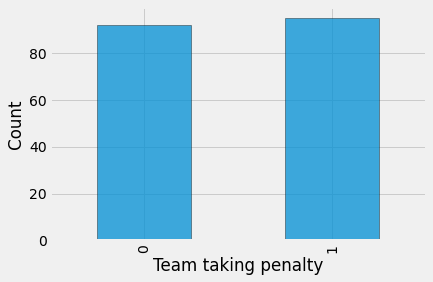

In [ ]:
df_serie_a['Team taking pen'].groupby(df_serie_a["Team taking pen"]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xlabel('Team taking penalty')
plt.ylabel('Count')
plt.show()

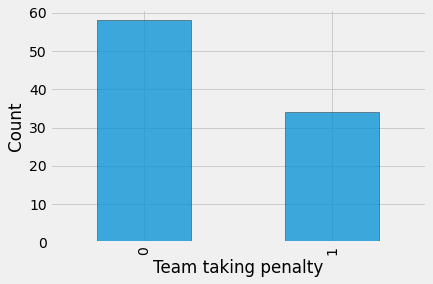

In [ ]:
df_ligue1['Team taking pen'].groupby(df_ligue1["Team taking pen"]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xlabel('Team taking penalty')
plt.ylabel('Count')
plt.show()

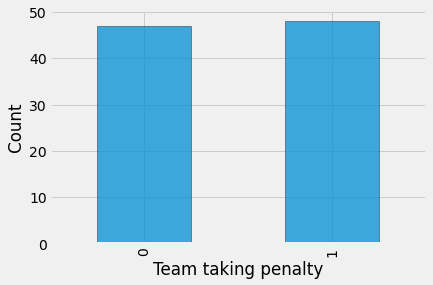

In [ ]:
df_premier['Team taking pen'].groupby(df_premier["Team taking pen"]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xlabel('Team taking penalty')
plt.ylabel('Count')
plt.show()

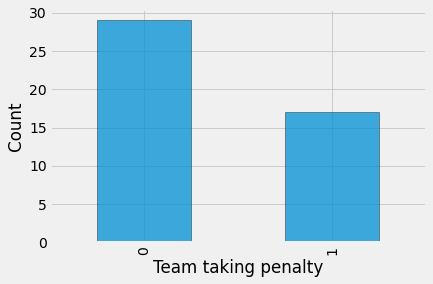

In [ ]:
df_champ['Team taking pen'].groupby(df_champ["Team taking pen"]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xlabel('Team taking penalty')
plt.ylabel('Count')
plt.show()

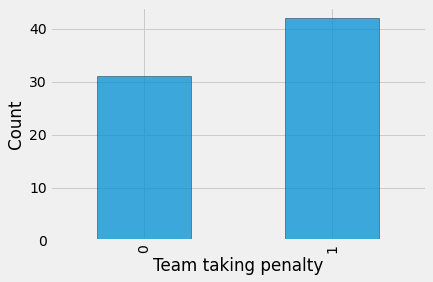

In [ ]:
df_bundes['Team taking pen'].groupby(df_bundes["Team taking pen"]).count().plot(kind="bar", edgecolor='black', alpha=0.75)
plt.xlabel('Team taking penalty')
plt.ylabel('Count')
plt.show()

# ROC-AUC and confidence intervals

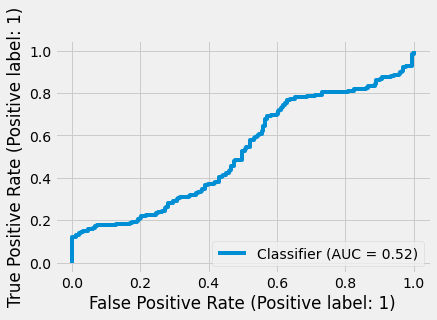

In [ ]:
y = df_dumpy['Scored'].values
t = df_dumpy['Team taking pen'].values
p = df_dumpy['P'].values

sklearn.metrics.roc_auc_score(t, p)
sklearn.metrics.RocCurveDisplay.from_predictions(t, p)

In [ ]:
def ci_percentile_bootstrap(df, func, x_covariates=[], use_ipw=False, B=400, alpha=0.05):
    ATTs_estimates = []
    ATEs_estimates = []
    for b in tqdm(range(B)):
        bootstrap_sample = df.sample(len(df), replace=True)
        x = bootstrap_sample[x_covariates].values
        t = bootstrap_sample["Team taking pen"].values
        y = bootstrap_sample['Scored'].values
        # estimating ATT, ATE
        if use_ipw:
            # calculating propensity scores using logistic regression
            propensity_data1 = make_pipeline(CalibratedClassifierCV(LogisticRegression())).fit(x, t)
            bootstrap_sample['P'] = propensity_data1.predict_proba(x)[:, 1]
            p_ATT_bootstrap, p_ATE_bootstrap = func(bootstrap_sample)
        else:
            p_ATT_bootstrap, p_ATE_bootstrap = func(bootstrap_sample, x_covariates)
        ATTs_estimates.append(p_ATT_bootstrap)
        ATEs_estimates.append(p_ATE_bootstrap)

    percentiles_ATT = sorted(ATTs_estimates)
    upper_percentile_ATT = np.percentile(percentiles_ATT, 100 - (alpha * 100) / 2)  # 0.975
    lower_percentile_ATT = np.percentile(percentiles_ATT, (alpha * 100) / 2)  # 0.025
    ci_ATT = (lower_percentile_ATT, upper_percentile_ATT)

    percentiles_ATE = sorted(ATEs_estimates)
    upper_percentile_ATE = np.percentile(percentiles_ATE, 100 - (alpha * 100) / 2)  # 0.975
    lower_percentile_ATE = np.percentile(percentiles_ATE, (alpha * 100) / 2)  # 0.025
    ci_ATE = (lower_percentile_ATE, upper_percentile_ATE)
    return ci_ATT, ci_ATE

In [ ]:
np.random.seed(42)
p_ci_ATT, p_ci_ATE = ci_percentile_bootstrap(df_dumpy, ipw, x_covariates=x_covariates, use_ipw=True)
print()
print(f"ipw ATT Confidence Interval: {p_ci_ATT[0].round(4), p_ci_ATT[1].round(4)}")
print(f"ipw ATE Confidence Interval: {p_ci_ATE[0].round(4), p_ci_ATE[1].round(4)}")

100%|██████████| 400/400 [01:26<00:00,  4.62it/s]


ipw ATT Confidence Interval: (-0.1703, -0.0306)
ipw ATE Confidence Interval: (-0.1685, -0.0014)


In [ ]:
print(f"ipw ATT Confidence Interval: {p_ci_ATT[0].round(4), p_ci_ATT[1].round(4)}")
print(f"ipw ATE Confidence Interval: {p_ci_ATE[0].round(4), p_ci_ATE[1].round(4)}")

ipw ATT Confidence Interval: (-0.1703, -0.0306)
ipw ATE Confidence Interval: (-0.1685, -0.0014)


In [ ]:
np.random.seed(42)
match_ci_ATT, match_ci_ATE = ci_percentile_bootstrap(df_dumpy, matching, x_covariates=x_covariates, use_ipw=False)
print()
print(f"matching ATT Confidence Interval: {match_ci_ATT[0].round(4), match_ci_ATT[1].round(4)}")
print(f"matching ATE Confidence Interval: {match_ci_ATE[0].round(4), match_ci_ATE[1].round(4)}")

100%|██████████| 400/400 [03:13<00:00,  2.06it/s]


matching ATT Confidence Interval: (-0.1838, -0.0045)
matching ATE Confidence Interval: (-0.1521, -0.002)


In [ ]:
print(f"matching ATT Confidence Interval: {match_ci_ATT[0].round(4), match_ci_ATT[1].round(4)}")
print(f"matching ATE Confidence Interval: {match_ci_ATE[0].round(4), match_ci_ATE[1].round(4)}")

matching ATT Confidence Interval: (-0.1838, -0.0045)
matching ATE Confidence Interval: (-0.1521, -0.002)


In [ ]:
np.random.seed(42)
t_ci_ATT, t_ci_ATE = ci_percentile_bootstrap(df_dumpy, t_learner, x_covariates=x_covariates, use_ipw=False)
print()
print(f"t_learner ATT Confidence Interval: {t_ci_ATT}")
print(f"t_learner ATE Confidence Interval: {t_ci_ATE}")

100%|██████████| 400/400 [02:01<00:00,  3.30it/s]


t_learner ATT Confidence Interval: (-0.19884016413092295, -0.045579039569043016)
t_learner ATE Confidence Interval: (-0.12819796591127805, 0.006637259081428993)


In [ ]:
print(f"t_learner ATT Confidence Interval: {t_ci_ATT[0].round(4), t_ci_ATT[1].round(4)}")
print(f"t_learner ATE Confidence Interval: {t_ci_ATE[0].round(4), t_ci_ATE[1].round(4)}")

t_learner ATT Confidence Interval: (-0.1988, -0.0456)
t_learner ATE Confidence Interval: (-0.1282, 0.0066)


In [ ]:
np.random.seed(42)
s_ci_ATT, s_ci_ATE = ci_percentile_bootstrap(df_dumpy, s_learner, x_covariates=x_covariates, use_ipw=False)
print()
print(f"s_learner ATT Confidence Interval: {s_ci_ATT}")
print(f"s_learner ATE Confidence Interval: {s_ci_ATE}")

100%|██████████| 400/400 [01:52<00:00,  3.54it/s]


s_learner ATT Confidence Interval: (-0.062482198078643914, 0.0008033192807280505)
s_learner ATE Confidence Interval: (-0.061084103077949224, 0.0016795478225603794)


In [ ]:
print(f"s_learner ATT Confidence Interval: {s_ci_ATT[0].round(4), s_ci_ATT[1].round(4)}")
print(f"s_learner ATE Confidence Interval: {s_ci_ATE[0].round(4), s_ci_ATE[1].round(4)}")

s_learner ATT Confidence Interval: (-0.0625, 0.0008)
s_learner ATE Confidence Interval: (-0.0611, 0.0017)


In [ ]:
# function for plotting the intervals
def show_intervals(int_list, kind):
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,7))
  for i in range(len(int_list)):
    # seperate some coefficients from others because of different scales
    # if i != 0 and i != 4:
    if kind == 'ATE':
      axs.plot(int_list[i],(i,i),'ro-',color='orange')
      axs.plot(ate_list[i],i,'o',color='black')

    if kind == 'ATT':
      axs.plot(int_list[i],(i,i),'ro-',color='orange')
      axs.plot(att_list[i],i,'o',color='black')
    # else:
    #   axs[1].plot(int_list[i],(i,i),'ro-',color='orange')
    #   axs[1].plot(beta_hat_full[i],i,'.',color='black')

  axs.set_yticks([0,1,2,3])    
  axs.set_yticklabels(['Propensity','S-Learner', 'T-Learner', 'Matching'])    
  fig.suptitle(' Confidence intervals according to '+kind, fontsize=18)
  # fig.text(0.09,0.5, "Coefficient:", ha="center", va="center", rotation=90, fontsize=15)
  plt.show()

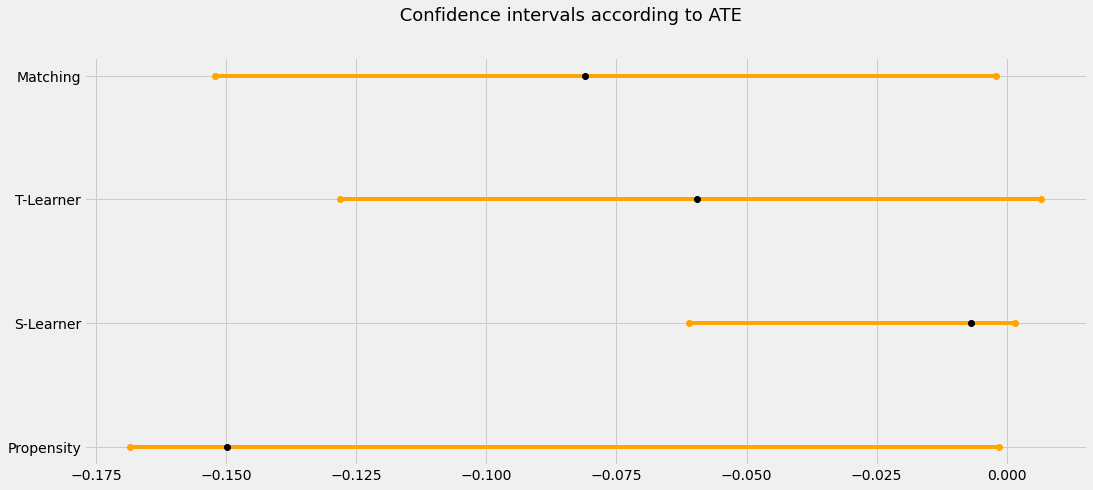

In [ ]:
show_intervals([p_ci_ATE, s_ci_ATE, t_ci_ATE, match_ci_ATE], 'ATE')

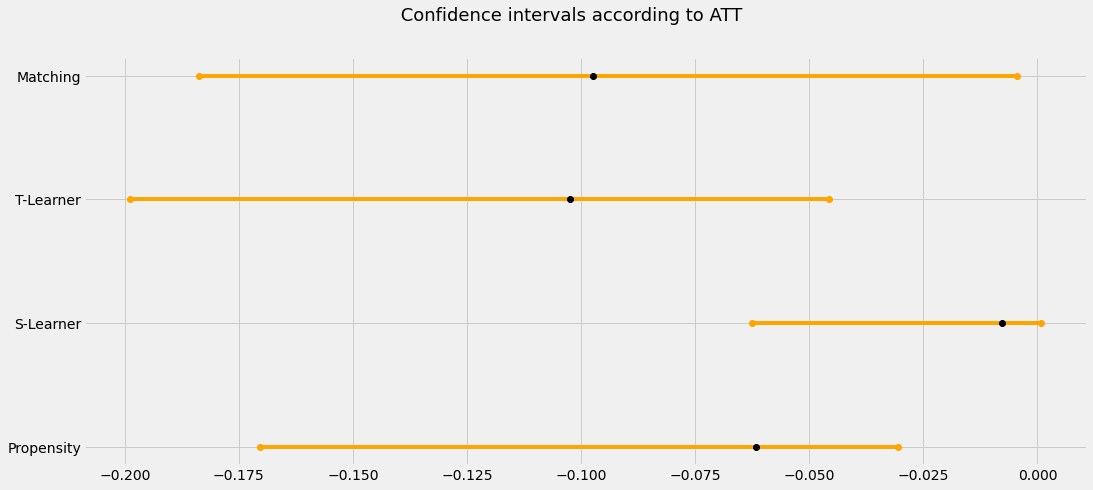

In [ ]:
show_intervals([p_ci_ATT, s_ci_ATT, t_ci_ATT, match_ci_ATT], 'ATT')

In [ ]:
pd.options.display.float_format = '{:.3f}'.format
ate_list = [p_ATE, s_ATE, t_ATE, match_ATE]
att_list = [p_ATT, s_ATT, t_ATT, match_ATT]
ate_ci_list = [[p_ci_ATE[0].round(4), p_ci_ATE[1].round(4)], 
               [s_ci_ATE[0].round(4), s_ci_ATE[1].round(4)], 
               [t_ci_ATE[0].round(4), t_ci_ATE[1].round(4)], 
               [match_ci_ATE[0].round(4), match_ci_ATE[1].round(4)]]
att_ci_list = [[p_ci_ATT[0].round(4), p_ci_ATT[1].round(4)], 
               [s_ci_ATT[0].round(4), s_ci_ATT[1].round(4)], 
               [t_ci_ATT[0].round(4), t_ci_ATT[1].round(4)], 
               [match_ci_ATT[0].round(4), match_ci_ATT[1].round(4)]]

df_table = pd.DataFrame({'ATE': ate_list, 'ATE confidence interval':ate_ci_list, 'ATT': att_list, 
                          'ATT confidence interval':att_ci_list}, 
                        ['Propensity', 'S-learner', 'T-learner', 'Matching'])
df_table = df_table.style.set_caption('ATE and ATT per method').set_properties(**{'text-align': 'center'})
df_table

,ATE,ATE confidence interval,ATT,ATT confidence interval
Propensity,-0.149791,"[-0.1685, -0.0014]",-0.061699,"[-0.1703, -0.0306]"
S-learner,-0.006900,"[-0.0611, 0.0017]",-0.007679,"[-0.0625, 0.0008]"
T-learner,-0.059446,"[-0.1282, 0.0066]",-0.102386,"[-0.1988, -0.0456]"
Matching,-0.081136,"[-0.1521, -0.002]",-0.097458,"[-0.1838, -0.0045]"
